# Canny Edge Detection Assignment - CS4372 - Machine Vision

### Building Canny Edge Detection from scratch

1. Converts color images to grayscale.
2. Uses a Gaussian filter to reduce image noise.
3. Estimates gradient strength and direction.
4. Ensures edges are one-pixel thick by keeping only the strongest gradients.
5. Connects strong gradient pixels using a dual threshold.

### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

## Step 1: Convert an RGB image to grayscale using the luminance method

In [2]:
def rgb_to_grayscale(image):
    """
    Convert an RGB image to grayscale using the luminance method.

    Parameters:
        image (numpy.ndarray): Input RGB image.

    Returns:
        numpy.ndarray: Grayscale image.
    """
    # Define the weights for RGB channels to calculate luminance
    weights = [0.2989, 0.5870, 0.1140]
    grayscale_image = np.dot(image[..., :3], weights).astype(np.uint8)

    return grayscale_image

### Generate a 2D Gaussian kernel.

In [3]:
def gaussian_kernel(size):
    """
    Generate a 2D Gaussian kernel.

    Parameters:
        size (int): Size of the kernel (should be an odd number).

    Returns:
        numpy.ndarray: 2D Gaussian kernel.
    """
    sigma = 0.3 * ((size - 1) * 0.5 - 1) + 0.8
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-((x**2 + y**2) / (2.0 * sigma**2)))
    return g / np.sum(g)

### Perform 2D convolution between an image and a kernel.

In [4]:
def convolution(image, kernel):
    """
    Perform 2D convolution between an image and a kernel.

    Parameters:
        image (numpy.ndarray): Input image.
        kernel (numpy.ndarray): Convolution kernel.

    Returns:
        numpy.ndarray: Convolved image.
    """
    image_height, image_width = image.shape
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2
    output = np.zeros_like(image, dtype=np.float64)

    for i in range(pad_size, image_height - pad_size):
        for j in range(pad_size, image_width - pad_size):
            output[i, j] = np.sum(image[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1] * kernel)

    return output

## Step 2: Filter image with a Gaussian kernel to remove noise

In [5]:
def gaussian_blur(image, kernel_size=5):
    """
    Apply Gaussian blur to an image.

    Parameters:
        image (numpy.ndarray): Input image.
        kernel_size (int, optional): Size of the Gaussian kernel. Default is 5.

    Returns:
        numpy.ndarray: Blurred image.
    """
    kernel = gaussian_kernel(kernel_size)
    return convolution(image, kernel)

### Generate regions from an input image.

In [6]:
def iterate_regions(image, kernel_size):
    """
    Generate regions from an input image.

    Parameters:
        image (numpy.ndarray): Input image.
        kernel_size (int): Size of the region.

    Yields:
        tuple: A tuple containing the region, its starting row (i), and starting column (j).
    """
    height, width = image.shape

    regions = [
        (image[i:(i + kernel_size), j:(j + kernel_size)], i, j)
        for i in range(height - kernel_size + 1)
        for j in range(width - kernel_size + 1)
    ]

    for region in regions:
        yield region

## Step 3: Estimate gradient strength and direction

In [7]:
def sobel(image, filtering_type):
    """
    Apply Sobel edge detection to an input image.

    Parameters:
        image (numpy.ndarray): Input grayscale image.
        filtering_type (str): Type of Sobel filter ('dx' for horizontal, 'dy' for vertical, 'magnitude' for both).

    Returns:
        tuple: A tuple containing two numpy arrays - the filtered image and the gradient angles.
    """
    height, width = image.shape

    # Define Sobel filter kernels
    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    Gx = np.zeros((height - 2, width - 2))
    Gy = np.zeros((height - 2, width - 2))


    regions = [
        (image[i:(i + 3), j:(j + 3)], i, j)
        for i in range(height - 3 + 1)
        for j in range(width - 3 + 1)
    ]


    for region, i, j in regions:
        if filtering_type == 'dx':
            Gx[i, j] += np.sum(region * horizontal)
        elif filtering_type == 'dy':
            Gy[i, j] += np.sum(region * vertical)
        elif filtering_type == 'magnitude':
            Gx[i, j] += np.sum(region * horizontal)
            Gy[i, j] += np.sum(region * vertical)


    gradient = np.sqrt(Gx**2 + Gy**2)
    gradient = np.pad(gradient, (1, 1), 'constant')

    angle = np.arctan2(Gy, Gx)
    angle = np.pad(angle, (1, 1), 'constant')


    output = (255 * np.int32(gradient > 255) + gradient * np.int32(gradient <= 255))
    angle += math.pi * np.int32(angle < 0)

    return output, angle


## Step 4: Ensure the edge is one pixel thick by suppressing non-maximum gradients along direction normal to the gradient

In [8]:
def non_maximum_suppression(gradient, angle):
    """
    Apply non-maximum suppression to an image gradient based on gradient angles.

    Parameters:
        gradient (numpy.ndarray): Gradient magnitudes of the image.
        angle (numpy.ndarray): Gradient angles of the image in radians.

    Returns:
        numpy.ndarray: Image after non-maximum suppression.
    """
    gradient_copy = gradient.copy()
    height, width = gradient.shape

    for j in range(1, height - 1):
        for i in range(1, width - 1):
            current_angle = angle[j, i]
            current_gradient = gradient[j, i]

            angle_range_1 = (0 <= current_angle < 22.5 / 180 * math.pi) or (157.5 / 180 * math.pi <= current_angle < math.pi)
            angle_range_2 = (22.5 / 180 * math.pi <= current_angle < 67.5 / 180 * math.pi)
            angle_range_3 = (67.5 / 180 * math.pi <= current_angle < 112.5 / 180 * math.pi)
            angle_range_4 = (112.5 / 180 * math.pi <= current_angle < 157.5 / 180 * math.pi)

            if angle_range_1:
                if current_gradient < gradient[j, i - 1] or current_gradient < gradient[j, i + 1]:
                    gradient_copy[j, i] = 0
            elif angle_range_2:
                if current_gradient < gradient[j - 1, i - 1] or current_gradient < gradient[j + 1, i + 1]:
                    gradient_copy[j, i] = 0
            elif angle_range_3:
                if current_gradient < gradient[j - 1, i] or current_gradient < gradient[j + 1, i]:
                    gradient_copy[j, i] = 0
            elif angle_range_4:
                if current_gradient < gradient[j + 1, i - 1] or current_gradient < gradient[j - 1, i + 1]:
                    gradient_copy[j, i] = 0

    return gradient_copy


## Step 5: Link edge maximum gradient pixels using a dual threshold

In [9]:
def apply_edge_threshold(image, lower_thresh, upper_thresh):
    """
    Apply edge thresholding to an image.

    Parameters:
        image (numpy.ndarray): Input image.
        lower_thresh (int): Lower threshold value.
        upper_thresh (int): Upper threshold value.

    Returns:
        numpy.ndarray: Thresholded edge image.
    """
    weak_value = 25
    strong_value = 255

    img_height, img_width = image.shape
    strong_i, strong_j = np.where(image >= upper_thresh)
    weak_i, weak_j = np.where((image < upper_thresh) & (image >= lower_thresh))

    edge_img = np.zeros_like(image, dtype=np.uint8)
    edge_img[strong_i, strong_j] = strong_value

    i, j = 1, 1
    while i < img_height - 1:
        while j < img_width - 1:
            current_pixel = image[i, j]
            if (current_pixel >= lower_thresh) and (current_pixel <= upper_thresh):
                if (image[i-1:i+2, j-1:j+2] >= upper_thresh).any():
                    edge_img[i, j] = strong_value
                else:
                    edge_img[i, j] = weak_value
            j += 1
        i += 1
        j = 1

    return edge_img


### Additional function to trace and connect weak edges

In [10]:
def trace_connected_edges(image, weak_value):
    """
    Trace and connect weak edges in the image.

    Parameters:
        image (numpy.ndarray): Input image containing weak edges.
        weak_value (int): Value representing weak edges.

    Returns:
        numpy.ndarray: Image with connected edges.
    """
    img_height, img_width = image.shape
    result_image = image.copy()
    x_coords, y_coords = np.where(image == 255)
    x_coords = x_coords.tolist()
    y_coords = y_coords.tolist()

    for idx in range(len(x_coords)):
        current_x = x_coords[idx]
        current_y = y_coords[idx]
        if current_x + 1 <= img_height and current_x - 1 >= 0 and current_y + 1 <= img_width and current_y - 1 >= 0:
            new_x, new_y = np.where(result_image[current_x-1:current_x+1+1, current_y-1:current_y+1+1] == weak_value)
            new_x = new_x + current_x - 1
            new_y = new_y + current_y - 1
            if len(new_x) > 0:
                result_image[new_x, new_y] = 255
                x_coords.extend(new_x)
                y_coords.extend(new_y)

    result_image[result_image == weak_value] = 0
    return result_image


In [11]:
image_name = 'cat.jpeg'

In [12]:
image = cv2.imread(image_name, cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

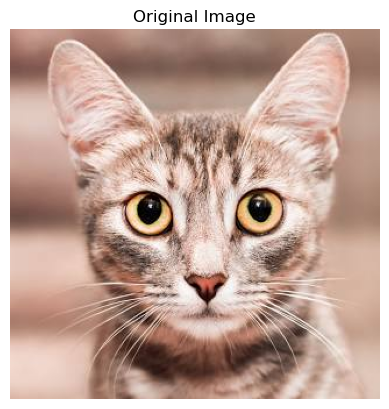

In [13]:
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [14]:
gray_image = rgb_to_grayscale(image_rgb)

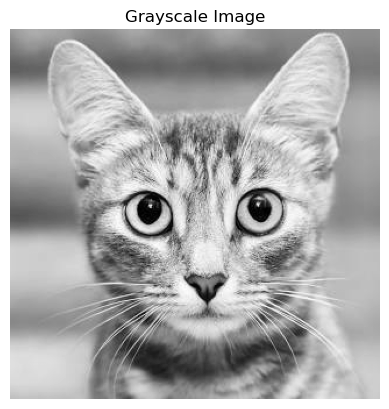

In [15]:
plt.imshow(gray_image,cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

In [16]:
blurred_image = gaussian_blur(gray_image)

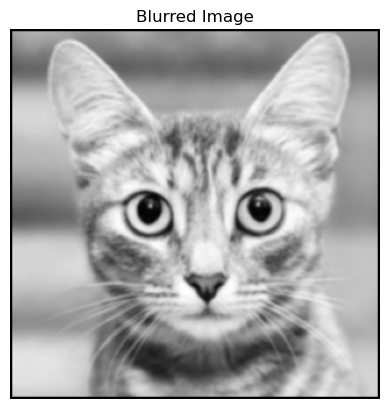

In [17]:
plt.imshow(blurred_image, cmap='gray')
plt.title("Blurred Image")
plt.axis('off')
plt.show()

In [18]:
gradient_magnitude, gradient_direction = sobel(blurred_image, 'magnitude')

In [19]:
nms_image = non_maximum_suppression(gradient_magnitude, gradient_direction)

In [20]:
lower_threshold = 30
upper_threshold = 50
thresholded_image = apply_edge_threshold(nms_image, lower_threshold, upper_threshold)

In [21]:
result_image = trace_connected_edges(thresholded_image, 25)

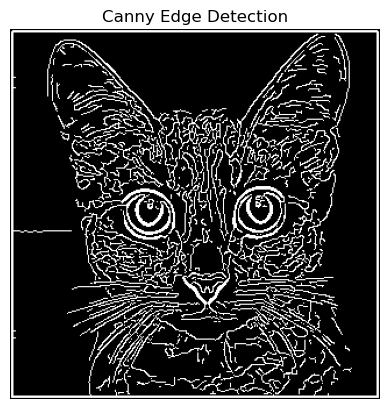

In [22]:
plt.imshow(result_image, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')
plt.show()

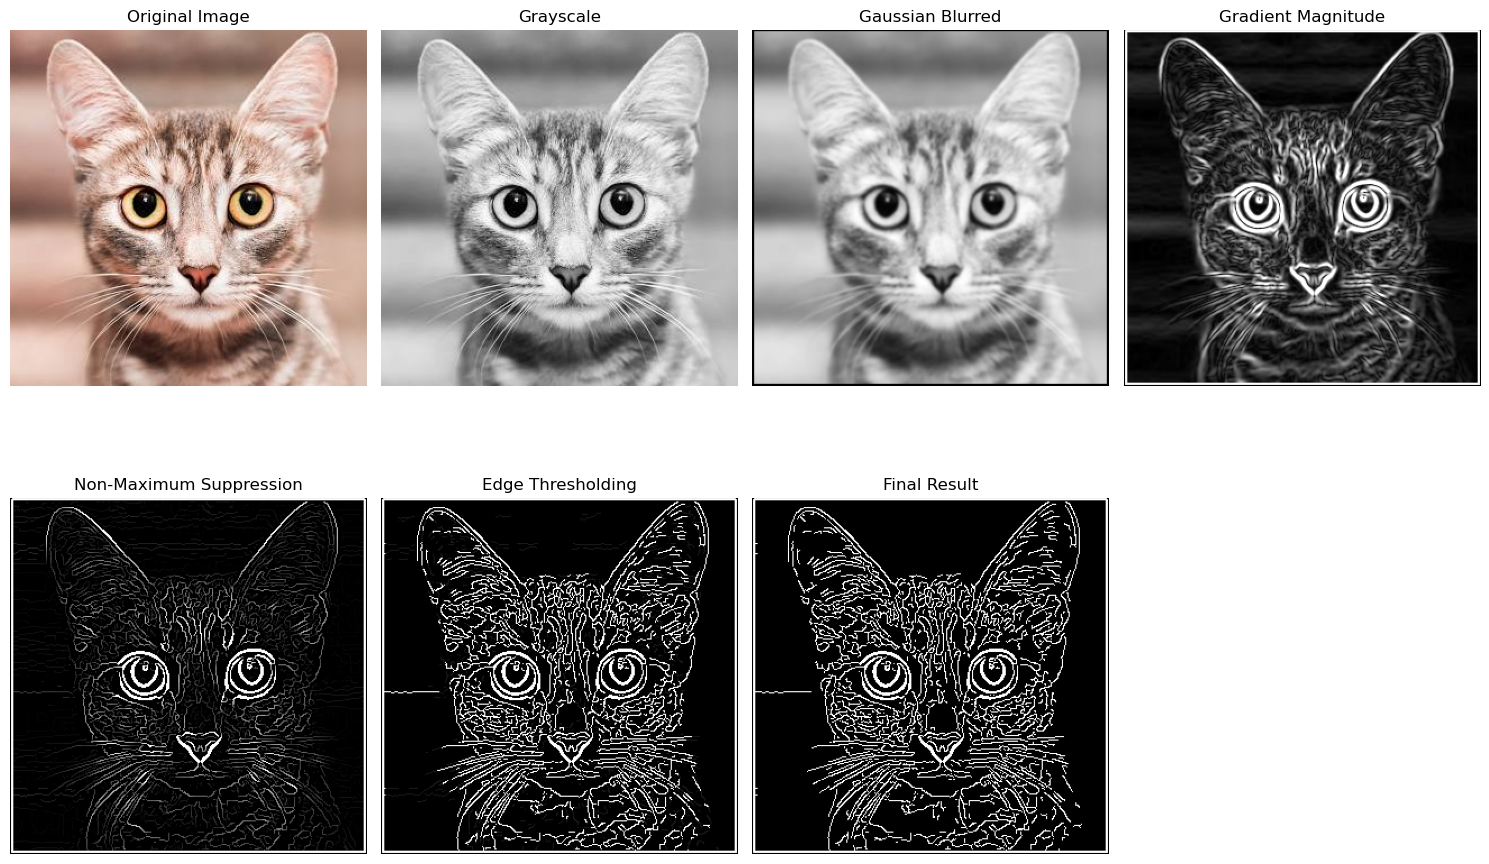

In [23]:
plt.figure(figsize=(15, 10))

plt.subplot(241)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(242)
plt.title("Grayscale")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

plt.subplot(243)
plt.title("Gaussian Blurred")
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')

plt.subplot(244)
plt.title("Gradient Magnitude")
plt.imshow(gradient_magnitude, cmap='gray')
plt.axis('off')

plt.subplot(245)
plt.title("Non-Maximum Suppression")
plt.imshow(nms_image, cmap='gray')
plt.axis('off')

plt.subplot(246)
plt.title("Edge Thresholding")
plt.imshow(thresholded_image, cmap='gray')
plt.axis('off')

plt.subplot(247)
plt.title("Final Result")
plt.imshow(result_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

### Save the final image

In [24]:
output_filename = f"Canny Edge Detection_{image_name}" 
cv2.imwrite(output_filename, result_image) 

True

# Verify using OpenCV (only for verification purpose).

In [25]:
gray_image_opencv = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred_image_opencv = cv2.GaussianBlur(gray_image_opencv, (5, 5), 0)

sobel_x_opencv = cv2.Sobel(blurred_image_opencv, cv2.CV_64F, 1, 0, ksize=3)
sobel_y_opencv = cv2.Sobel(blurred_image_opencv, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude_opencv = np.sqrt(sobel_x_opencv**2 + sobel_y_opencv**2)
gradient_direction_opencv = np.arctan2(sobel_y_opencv, sobel_x_opencv)


lower_threshold = 30
upper_threshold = 50
canny_edge_image_opencv = cv2.Canny(blurred_image_opencv, lower_threshold, upper_threshold)

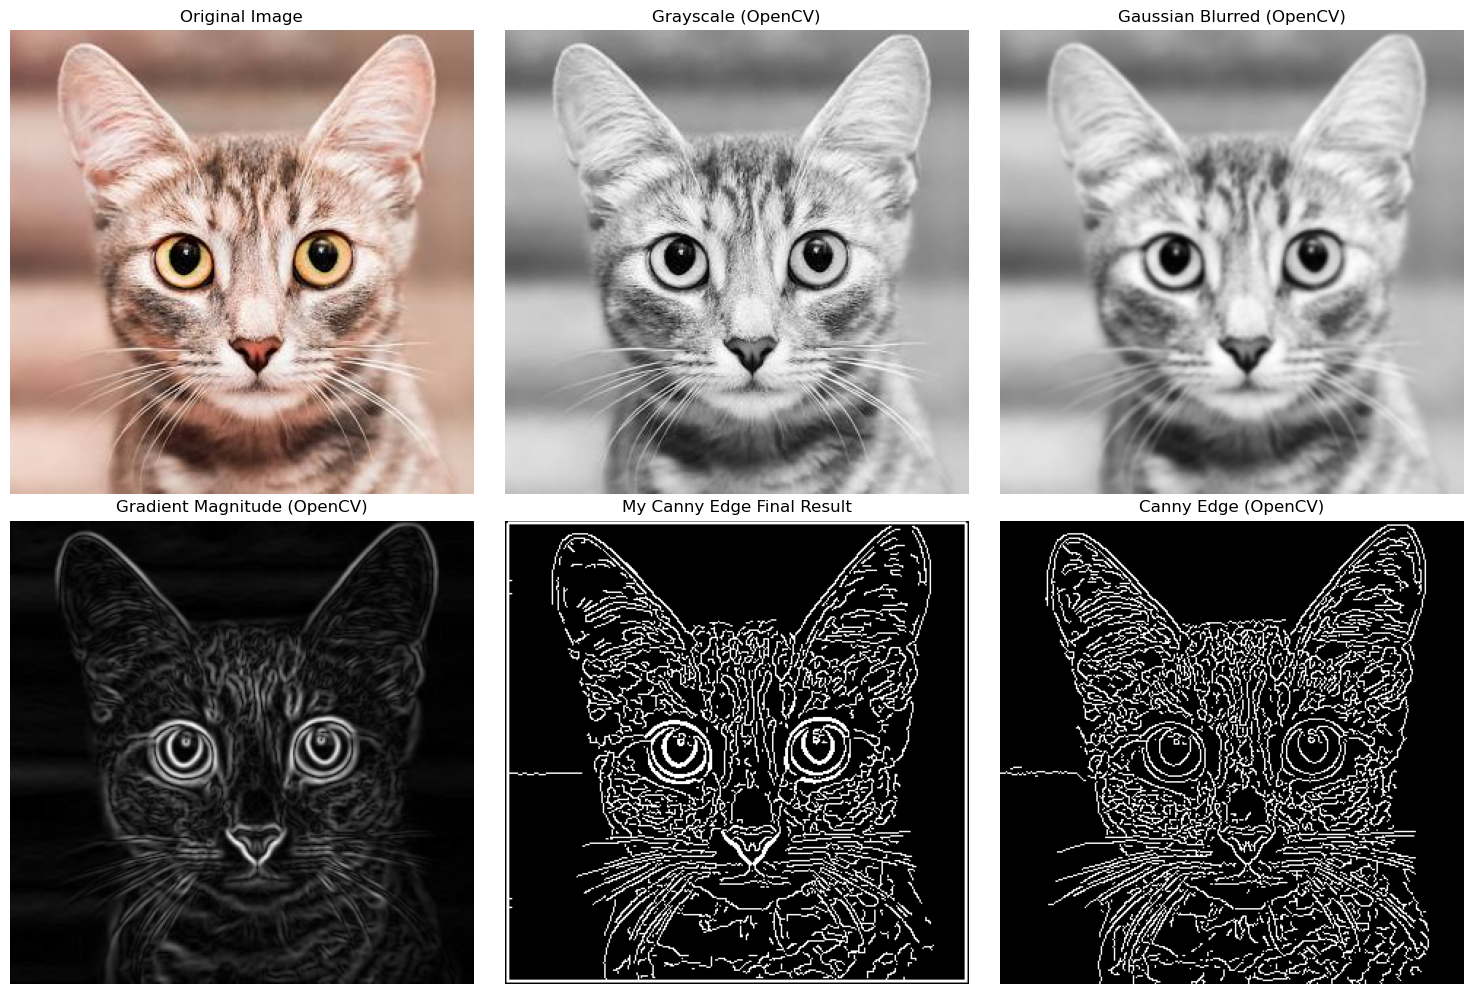

In [26]:
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(232)
plt.title("Grayscale (OpenCV)")
plt.imshow(gray_image_opencv, cmap='gray')
plt.axis('off')

plt.subplot(233)
plt.title("Gaussian Blurred (OpenCV)")
plt.imshow(blurred_image_opencv, cmap='gray')
plt.axis('off')

plt.subplot(234)
plt.title("Gradient Magnitude (OpenCV)")
plt.imshow(gradient_magnitude_opencv, cmap='gray')
plt.axis('off')

plt.subplot(235)
plt.title("My Canny Edge Final Result")
plt.imshow(result_image, cmap='gray')
plt.axis('off')

plt.subplot(236)
plt.title("Canny Edge (OpenCV)")
plt.imshow(canny_edge_image_opencv, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
